# CAST Demo

Setup of Cassie/AmberUAV CAST demo

In [1]:
import polytope as pc
from collections import OrderedDict
import numpy as np

prob = {}
prob['cas_T'] = 15
prob['uav_T'] = 30
prob['cas_x0'] = np.array([0.25, 0.75])
prob['uav_x0'] = np.array([0.25, 3.25])
prob['uav_xT'] = np.array([0.25, 3.25])

prob['prob_margin'] = 0.1

prob['formula'] = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( sampleC ) )'

regs = OrderedDict()
regs['r1'] = (pc.box2poly(np.array([[3, 6], [1, 1.5]])), 0.5, 'red')
regs['r2'] = (pc.box2poly(np.array([[3, 6], [2.5, 3]])), 1, 'red')
regs['r3'] = (pc.box2poly(np.array([[4, 4.5], [3, 4]])), 0.5, 'red')
regs['a1'] = (pc.box2poly(np.array([[5.5, 6], [1.5, 2.5]])), 0.5, 'green')
regs['b1'] = (pc.box2poly(np.array([[5.5, 6], [0, 0.5]])), 0.5, 'blue')
regs['c1'] = (pc.box2poly(np.array([[5.5, 6], [3.5, 4]])), 0.5, 'blue')

prob['regs'] = regs
prob['env_x0'] = [0 if  reg[1] in [0,1] else 1 for reg in regs.values()]

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [2]:
# plot workspace
from best.abstraction.gridding import Abstraction
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import help_functions as hf

# cassie model
cassie_abstr = Abstraction([0, 0], [6, 4], [12, 8], name_prefix='c')

fig = plt.figure(figsize=(6, 4))
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
cassie_abstr.plot(ax)

for name, info in regs.items():
    hf.plot_region(ax, info[0], name, info[1], info[2])
    
ax.text(prob['cas_x0'][0], prob['cas_x0'][1], '$\\xi_c^0$')

ax.add_patch(patches.Rectangle(  prob['uav_xT'][:2]-0.25, 0.5, 0.5, fill=False ))
ax.text( prob['uav_x0'][0], prob['uav_x0'] [1], '$\\xi_u^0$')

plt.show()

<Figure size 600x400 with 1 Axes>

{1}


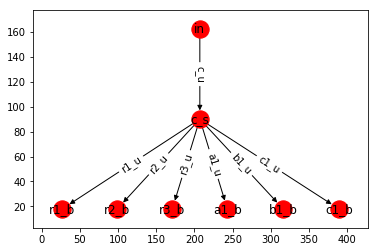

MDP network: (5,) inputs ('c_u',), (96, 3, 1, 3, 3, 3, 3) states ('c_s', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b'), (96, 3, 1, 3, 3, 3, 3) outputs ('c_x', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b')


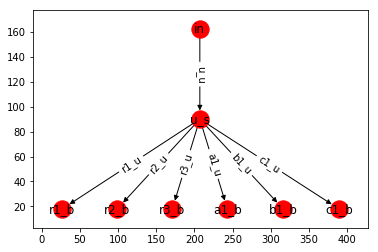

MDP network: (5,) inputs ('u_u',), (96, 3, 1, 3, 3, 3, 3) states ('u_s', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b'), (96, 3, 1, 3, 3, 3, 3) outputs ('u_x', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b')


In [3]:
# create systems
from best.models.pomdp import POMDPNetwork

# copter model
uav_abstr = Abstraction([0, 0], [6, 4], [12, 8], name_prefix='u')

# Environment belief model
env_list = [hf.environment_belief_model(info[1], name) for (name, info) in regs.items()]

# Construct rover-env network
cassie_env_network = POMDPNetwork([cassie_abstr.pomdp] + env_list)
for item in prob['regs'].items():
    cassie_env_network.add_connection(['c_x'], '{}_u'.format(item[0]), hf.get_cassie_env_conn(item))

conn = hf.get_cassie_env_conn( ('r1', prob['regs']['r1']) )
print(conn(np.array([4,2.05])))
    
# Construct copter-env network
uav_env_network = POMDPNetwork([uav_abstr.pomdp] + env_list)
for item in prob['regs'].items():
    uav_env_network.add_connection(['u_x'], '{}_u'.format(item[0]), hf.get_uav_env_conn(item))

cassie_env_network.plot()
plt.show()
print (cassie_env_network)

uav_env_network.plot()
plt.show()
print (uav_env_network)

In [4]:
# solve rover LTL problem
from best.solvers.valiter import solve_ltl_cosafe

predicates = hf.get_predicates(prob['regs'])
cassie_ltlpol = solve_ltl_cosafe(cassie_env_network, prob['formula'], predicates,
                                horizon=prob['cas_T'], verbose=True)

constructing augmented network...
finished constructing augmented network in 0.23s
iteration 0, time 0.00
iteration 1, time 0.14
iteration 2, time 0.24
iteration 3, time 0.34
iteration 4, time 0.43
iteration 5, time 0.53
iteration 6, time 0.63
iteration 7, time 0.72
iteration 8, time 0.83
iteration 9, time 0.92
iteration 10, time 1.02
iteration 11, time 1.12
iteration 12, time 1.22
iteration 13, time 1.31
iteration 14, time 1.41
finished after 1.50s and 15 iterations


In [5]:
from best.solvers.valiter import solve_reach_constrained

# set up target set
init_cas = cassie_abstr.x_to_s(prob['cas_x0'])
init_dfsa = cassie_ltlpol.dfsa_init
v_max = np.max(cassie_ltlpol.val[0].flatten())
idx = np.logical_or(cassie_ltlpol.val[0][init_cas, ..., init_dfsa] > v_max-prob['prob_margin'],
                    cassie_ltlpol.val[0][init_cas, ..., init_dfsa] < prob['prob_margin'])
Vacc = np.zeros(uav_env_network.N)
Vacc[:, idx] = 1

# constraint set (landing)
Vcon = np.zeros(uav_env_network.N)
Vcon[uav_abstr.x_to_s(prob['uav_xT']), :] = 1
val_uav_list, pol_uav_list = solve_reach_constrained(uav_env_network, 
                                                     Vacc, [(Vcon, 0.95)], 
                                                    horizon=prob['uav_T'], verbose=True)

iteration 0, time 0.00
iteration 1, time 0.03
iteration 2, time 0.06
iteration 3, time 0.08
iteration 4, time 0.11
iteration 5, time 0.15
iteration 6, time 0.18
iteration 7, time 0.20
iteration 8, time 0.23
iteration 9, time 0.26
iteration 10, time 0.28
iteration 11, time 0.30
iteration 12, time 0.33
iteration 13, time 0.36
iteration 14, time 0.38
iteration 15, time 0.40
iteration 16, time 0.42
iteration 17, time 0.45
iteration 18, time 0.48
iteration 19, time 0.51
iteration 20, time 0.54
iteration 21, time 0.57
iteration 22, time 0.59
iteration 23, time 0.61
iteration 24, time 0.64
iteration 25, time 0.66
iteration 26, time 0.69
iteration 27, time 0.72
iteration 28, time 0.74
iteration 29, time 0.76
finished after 0.79s and 30 iterations


In [6]:
from policies import *

# save controllers
uav_policy = UAVPolicy(pol_uav_list, val_uav_list, uav_abstr)
cas_policy = CassiePolicy(cassie_ltlpol, cassie_abstr)

if True:
    import pickle
    with open('policies.pickle', 'wb') as fp:
      pickle.dump((uav_policy, cas_policy, prob), fp)

success probability: 0.125


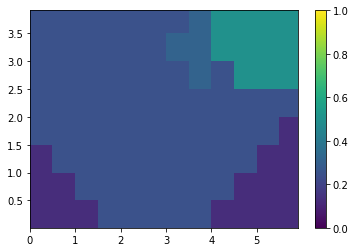

In [7]:
# plot rover value fcn
def my_value(x, mapstate):    
    s_abstr = cassie_abstr.x_to_s(x)
    _, val = cassie_ltlpol((s_abstr,) + tuple(mapstate))
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), prob['env_x0'])

xx, yy = np.meshgrid(np.arange(0.01, 5.99, 0.1), np.arange(0.01, 3.99, 0.1))
vals = np.vectorize(my_init_value)(xx, yy)

plt.pcolor(xx, yy, vals, vmin=0, vmax=1)
plt.colorbar()

print ('success probability: {}'.format(my_value(prob['cas_x0'], prob['env_x0'])))

success value: 0.75


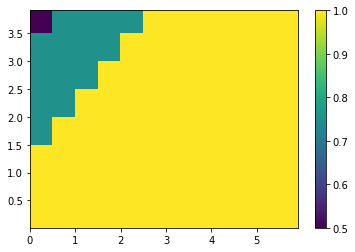

In [8]:
# plot copter value fcn
map_init = prob['env_x0']

def uav_value(x, mapstate):  
    scop = uav_abstr.x_to_s(x)
    return val_uav_list[0][(scop,) + tuple(mapstate)]

def my_init_cvalue(x, y):
    return uav_value(np.array([x, y]), map_init)

xx, yy = np.meshgrid(np.arange(0.01, 5.99, 0.1), np.arange(0.01, 3.99, 0.1))
vals = np.vectorize(my_init_cvalue)(xx, yy)

plt.pcolor(xx, yy, vals)
plt.colorbar()

print ('success value: {}'.format(uav_value(prob['uav_x0'], map_init)))